<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 99101581
Name = 'Daniyal'
Last_Name = 'Rasti'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [2]:
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision
# !pip install torch

## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

d:\Apps\Anaconda\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
## FILL HERE
# iterating through all data to count unique labels
unique_labels = set()
for sample in train_set:
    unique_labels.add(sample[1])
print ("number of unique labels: ", len(unique_labels))

input_dim = train_set[0][0].numel()
print ("input_dimension (number of pixels): ", input_dim)



number of unique labels:  10
input_dimension (number of pixels):  784


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

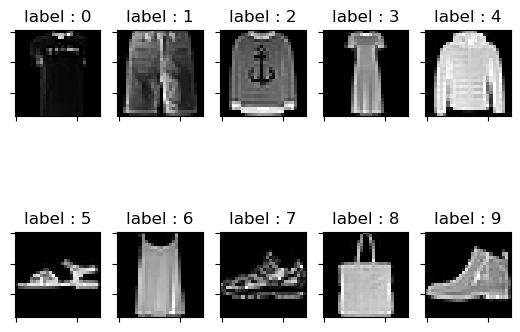

In [7]:
import random 

# this function returns indecies of all datapoints of each label
def get_indices_of_each_label(dataset, label_count):
    indices = [[] for _ in range (label_count)] # initiating
    # indices is a list of lists, indecies[i] is list of all indecies of datapoints with label i
    for i, (_, label) in enumerate(dataset):
        indices[label].append(i)
    return indices

indices = get_indices_of_each_label(train_set,len(unique_labels))

for label in range(len(unique_labels)):
    # getting a random sample of a specific label
    random_index = random.choice(indices[label])
    random_sample , _ = train_set[random_index]
    # plotting random sample
    image = random_sample.permute(1, 2, 0)
    plt.subplot(2,5,label+1)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.title("label : "+str(label))
    plt.imshow(image,cmap="gray")
plt.show()



## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
# input_dim : input dimention of the first layer, which you have calculated before.
num_classes = len(unique_labels)
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    """
    Affine transformation: computes output of a linear layer.
    
    Inputs:
    - x: Input tensor (B, D)
    - w: Weight tensor (D, H)
    - b: Bias tensor (H,)
    
    Returns:
    - out: Output tensor after affine transformation (B, H)
    """
    out = torch.matmul(x, w) + b
    return out


def relu(x):
    """
    ReLU activation function.
    
    Inputs:
    - x: Input tensor
    
    Returns:
    - out: Output tensor after ReLU activation
    """
    out = torch.maximum(torch.tensor(0.0, device=x.device), x)
    return out
    

Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    """
    Function to compute output of the entire model for input `x` using the given parameters.
    
    Inputs:
    - x: Input tensor (B, *)
    - parameters: Dictionary containing weights and biases for each layer
    - num_layers: Number of layers in the model
    
    Returns:
    - output: Output tensor of the model (B, num_classes)
    """
    B = x.shape[0]
    x = x.view(B, -1)
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b)
        if i < num_layers - 1:
            x = relu(x)
    output = x
    return output


Implementing cross entropy loss:

In [12]:
def cross_entropy_loss(scores, y):
    """
    Cross-entropy loss function.
    
    Inputs:
    - scores: Predicted scores from the model (B, num_classes)
    - y: True labels (B,)
    
    Returns:
    - loss: Scalar cross-entropy loss
    """
    n = len(y)
    exp_scores = torch.exp(scores)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    correct_logprobs = -torch.log(probs[range(n), y])
    loss = torch.sum(correct_logprobs) / n
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [13]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    """
    SGD optimizer function to update parameters based on gradients and zero out gradients afterward.

    Inputs:
    - parameters: Dictionary containing weights and biases for each layer
    - learning_rate: Learning rate for gradient descent

    Returns:
    - None (updates parameters in place)
    """
    with torch.no_grad():
        for param_name in parameters:
            parameters[param_name] -= learning_rate * parameters[param_name].grad
            parameters[param_name].grad.zero_()


Training functions:

In [14]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    """
    Calculate accuracy given predicted and true labels.
    
    Inputs:
    - y_pred: Predicted labels (numpy array)
    - y_true: True labels (numpy array)
    
    Returns:
    - acc: Accuracy (float)
    """
    correct = np.sum(y_pred == y_true)
    total = len(y_true)
    acc = correct / total
    return acc


def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    """
    Training loop for a single epoch.

    Inputs:
    - train_loader: DataLoader for training dataset
    - parameters: Dictionary containing weights and biases for each layer
    - learning_rate: Learning rate for SGD optimizer
    - epoch: Current epoch number (optional)

    Returns:
    - train_loss: Average training loss for the epoch
    - train_acc: Training accuracy for the epoch
    """
    train_loss = 0
    N_train = len(train_loader.dataset)
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        scores = model(x, parameters)
        loss = cross_entropy_loss(scores, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        
        train_loss += loss.item()
        y_pred = scores.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    train_acc = accuracy(Y_pred, Y)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}, Train Accuracy: {train_acc}')
    
    return train_loss / len(train_loader), train_acc

def validate(loader, parameters, set_name=None):
    """
    Validation loop to evaluate model performance on a dataset.
    
    Inputs:
    - loader: DataLoader for validation/test dataset
    - parameters: Dictionary containing weights and biases for each layer
    - set_name: Name of the dataset ('train', 'val', 'test')
    
    Returns:
    - val_loss: Average validation loss
    - val_acc: Validation accuracy
    """
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        scores = model(x, parameters)
        loss = cross_entropy_loss(scores, y)
        total_loss += loss.item()
        
        y_pred = scores.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    val_loss = total_loss / len(loader)
    val_acc = accuracy(Y_pred, Y)
    
    print(f'{set_name} set, Loss: {val_loss}, Accuracy: {val_acc}')
    
    return val_loss, val_acc


In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [16]:
def train_model(dataloaders, num_epochs, learning_rate=0.001):
    """
    Main function to train the model for multiple epochs and track performance metrics.
    
    Inputs:
    - dataloaders: List containing train and test DataLoader objects
    - num_epochs: Number of epochs to train
    - learning_rate: Learning rate for SGD optimizer
    
    Returns:
    - None (prints and plots training/validation metrics)
    """
    train_loader, test_loader = dataloaders
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, parameters, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        test_loss, test_acc = validate(test_loader, parameters, set_name='Test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    
    # Plotting the loss and accuracy curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Accuracy')
    plt.legend()
    
    plt.show()

Epoch 0, Train Loss: 2.2903990186353735, Train Accuracy: 0.33636666666666665
Test set, Loss: 2.2713160454087955, Accuracy: 0.4539
Epoch 1, Train Loss: 2.1405899651777514, Train Accuracy: 0.43685
Test set, Loss: 1.7590243011523203, Accuracy: 0.4931
Epoch 2, Train Loss: 1.244391619333072, Train Accuracy: 0.5511666666666667
Test set, Loss: 0.986108251058372, Accuracy: 0.5952
Epoch 3, Train Loss: 0.8787925341236058, Train Accuracy: 0.6587666666666666
Test set, Loss: 0.8628346506197742, Accuracy: 0.6689
Epoch 4, Train Loss: 0.776548709378822, Train Accuracy: 0.7161833333333333
Test set, Loss: 0.7566298595659292, Accuracy: 0.7307
Epoch 5, Train Loss: 0.7111156112921517, Train Accuracy: 0.74435
Test set, Loss: 0.7014845651426133, Accuracy: 0.7497
Epoch 6, Train Loss: 0.6568791791955545, Train Accuracy: 0.7645833333333333
Test set, Loss: 0.6628554820255109, Accuracy: 0.7617
Epoch 7, Train Loss: 0.6157581287025135, Train Accuracy: 0.7801333333333333
Test set, Loss: 0.6307589430717906, Accuracy:

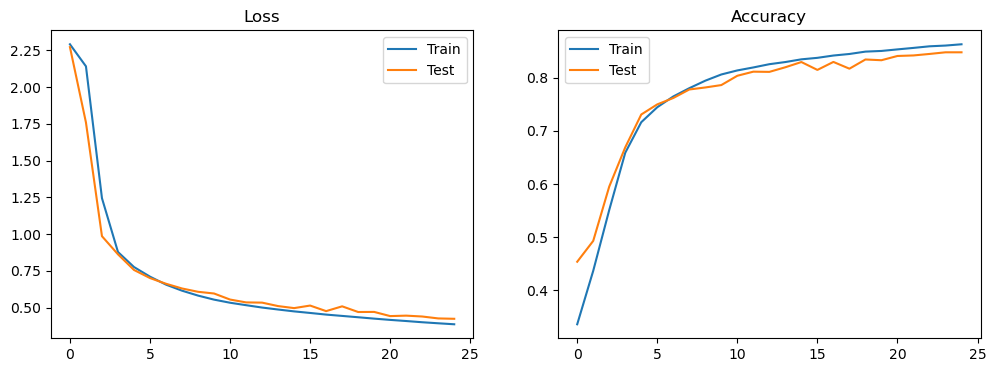

In [17]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1]}')

## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

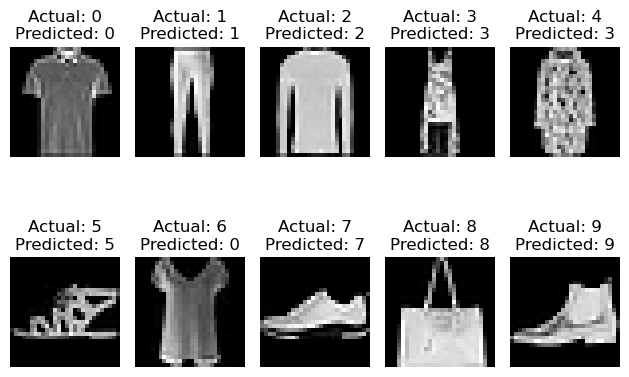

In [19]:
## FILL HERE
import matplotlib.pyplot as plt

def visualize_predictions(test_loader, parameters, num_classes):
    # Get one image from each class
    class_samples = {i: None for i in range(num_classes)}
    class_labels = {i: None for i in range(num_classes)}
    cnt  = 0
    with torch.no_grad():
        for x, y in test_loader:
            for i in range(len(y)):
                label = y[i].item()
                if class_samples[label] is None:
                    cnt +=1
                    class_samples[label] = x[i].unsqueeze(0)
                    class_labels[label] = y[i].unsqueeze(0)
            if cnt == num_classes:
                break

    # Pass these images through the model to get predictions
    for label, img_tensor in class_samples.items():
        img_tensor = img_tensor.to(device)
        pred = model(img_tensor, parameters)
        predicted_label = pred.argmax(dim=-1).item()
        
        # Plot the image
        img = img_tensor.squeeze().cpu().numpy()
        plt.subplot(2, 5, label + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader, parameters, len(unique_labels))
